In [0]:
__author__ = "Phillip Lakaschus"
__email__ = "lakaschus@th.physik.uni-frankfurt.de"

23.845964670181274


<Figure size 480x600 with 0 Axes>

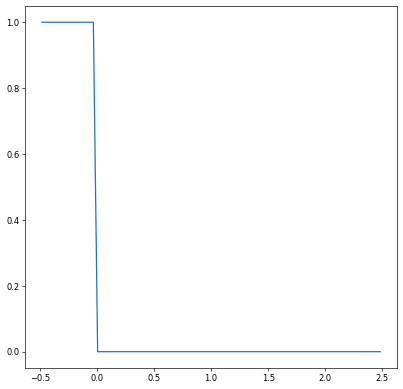

0.0


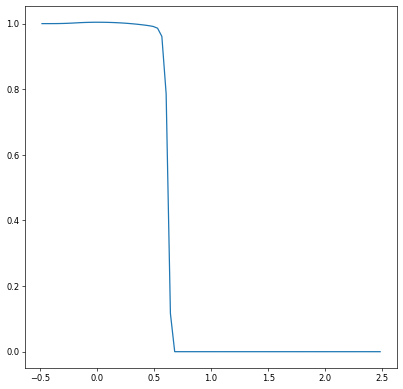

0.6464646464646465


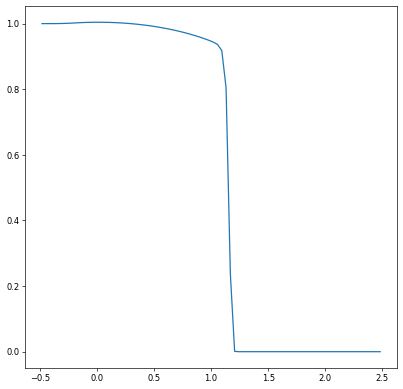

1.292929292929293


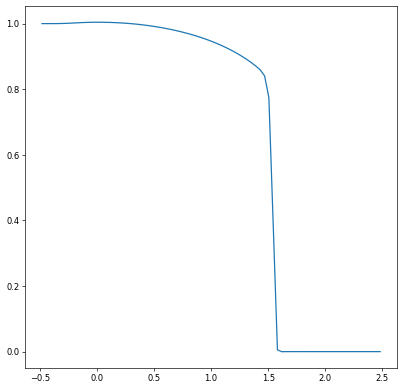

1.9393939393939394


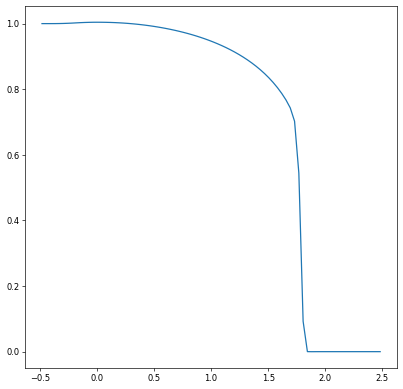

2.585858585858586


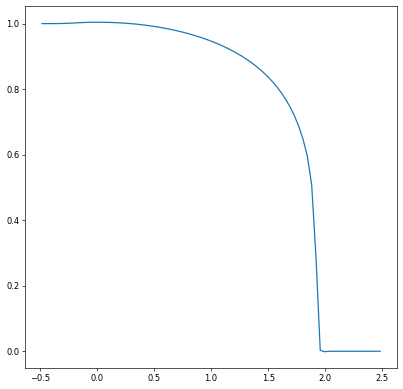

3.2323232323232327


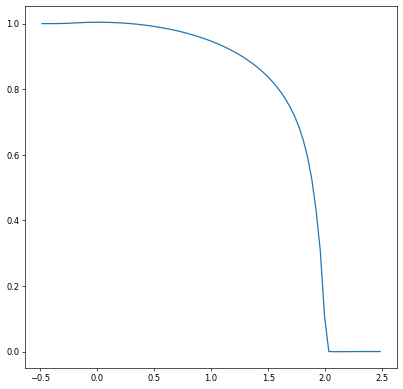

3.878787878787879
[ 0.00000000e+00 -5.21849577e-05 -4.31247783e-05 -3.62761283e-05
 -3.11370691e-05 -2.73672849e-05 -2.47402395e-05 -2.31081315e-05
 -2.24129418e-05 -2.26723123e-05 -2.38187254e-05 -2.56833834e-05
 -2.80744527e-05 -3.09367423e-05 -3.37512437e-05 -3.61801702e-05
 -3.80557928e-05 -3.92739995e-05 -3.99460088e-05 -4.01658943e-05
 -4.00895365e-05 -3.98240756e-05 -3.93613610e-05 -3.86832619e-05
 -3.76632939e-05 -3.64891078e-05 -3.53272385e-05 -3.42732404e-05
 -3.33895668e-05 -3.27265493e-05 -3.22600501e-05 -3.19671287e-05
 -3.18415401e-05 -3.18753255e-05 -3.20476894e-05 -3.23275533e-05
 -3.26864517e-05 -3.31051607e-05 -3.35046018e-05 -3.38390958e-05
 -3.40766329e-05 -3.42185046e-05 -3.42797706e-05 -3.42793697e-05
 -3.42461032e-05 -3.41753713e-05 -3.40667276e-05 -3.39087713e-05
 -3.36886512e-05 -3.34418177e-05 -3.31978016e-05 -3.29745822e-05
 -3.27804635e-05 -3.26191714e-05 -3.24946620e-05 -3.24018218e-05
 -3.23348568e-05 -3.22896300e-05 -3.22606465e-05 -3.22421993e-05
 -3.223

In [0]:
import time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import integrate
from scipy.integrate import odeint
from scipy.integrate import solve_ivp

%matplotlib inline

N = 80
xmax = 1
x = np.linspace(-0.5, 2.5, N+1)
N_t = 100
t = np.linspace(0, 4, N_t)

xc = 0.5*np.array(x[:-1]+x[1:])

dx = x[1] - x[0]

u0 = np.heaviside(-xc, 1)

start = time.time()  

def minmod(r):
  minmod = (r > 0).astype(int)
  minmod2 = (r < 1).astype(int)
  minmod3 = (r >= 1).astype(int)
  return minmod*minmod2*r + minmod3*np.ones(len(r)) 

def minmod2(a, b):
  minmod = (np.abs(a) < np.abs(b)).astype(int)
  minmod2 = (np.abs(b) < np.abs(a)).astype(int)
  return 1/2*(np.sign(a) + np.sign(b))*(minmod*np.abs(a) + minmod2*np.abs(b))

def minmod3(a, b):                                                               
    minmod = (a*b > 0).astype(int)                                              
    minmod2 = (a < 0).astype(int)*np.maximum(a, b)                              
    minmod3 = (a >= 0).astype(int)*np.minimum(a, b)                             
    return minmod*(minmod2*minmod3) 
  
def S(x, t):
  if x <= -0.4: return 0
  if x <= -0.2: return 1/2*(x + 0.4)
  else: return -1/2*x
  
def dudt(t, u):
  u = np.append(1, np.append(u, 0))
  
  limiter = minmod2((u[1:-1] - u[:-2])/dx, (u[2:] - u[1:-1])/dx)
  uLForw = u[0]
  uLCent = u[1:-1] + dx/2*limiter
  uL = np.append(uLForw, uLCent)
  
  uRBack = u[-1]
  uRCent = u[1:-1] - dx/2*limiter
  uR = np.append(uRCent, uRBack)

  FL = (uL + 3*uL**6)/4
  FR = (uR + 3*uR**6)/4
 
  FL_d = (1 + 3*6*uL**5)/4
  FR_d = (1 + 3*6*uR**5)/4
  
  prop = (np.abs(FL_d) >= np.abs(FR_d)).astype(int)*np.abs(FL_d) + (np.abs(FL_d) < np.abs(FR_d)).astype(int)*np.abs(FR_d)
    
  fu_interface = (FL + FR)/2 - prop/2*(uR - uL)
  
  eps = 0.01
  Q1 = eps*3*u[1:-1]**6*(u[2:] - u[1:-1])/dx
  Q2 = eps*3*u[2:]**6*(u[2:] - u[1:-1])/dx
  Q3 = eps*3*u[:-2]**6*(u[1:-1] - u[:-2])/dx
  Q4 = eps*3*u[1:-1]**6*(u[1:-1] - u[:-2])/dx
  
  Pp = 1/2*(Q1 + Q2)
  Pm = 1/2*(Q3 + Q4)

  source_term2 = np.zeros(N)
  for i in range(N):
    if u[i+1] > 0:
      source_term2[i] = S(x[i], t)
    else:
      source_term2[i] = max(S(x[i], t), 0)

  dudt =  (fu_interface[:-1] - fu_interface[1:])/dx + (Pp - Pm)/dx + source_term2
  return dudt
  
def solution(u0):
    t_span = [t[0], t[-1]]
    sol = solve_ivp(dudt, t_span, u0, t_eval = t)
    return sol.y

sol = solution(u0)

print(time.time()-start)

plt.figure(figsize=(8, 10), dpi= 60, facecolor='w', edgecolor='k')

for i in range(0, N_t, int(N_t/6)):
    plt.figure(figsize=(8, 8), dpi= 60, facecolor='w', edgecolor='k')
    plt.plot(xc, sol[:,i])
    plt.show()
    print(t[i])
    
print(sol[-1])